In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import json
from PIL import Image
import cv2 as cv
from datetime import datetime
from torchvision import models, datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset
import os
from pathlib import Path
import segmentation_models_pytorch as smp

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data prep

In [2]:
json_file=r"HuBMAP dataset\polygons.jsonl"
img_path=r"HuBMAP dataset\imgs"
tile_meta_path = r"HuBMAP dataset\tile_meta.csv"

SEED = 42

In [3]:
# Берем изображение по index, строим по нему изображение 9х9,с ним в центре,
# на этом изображении делаем random crop и учимся (+ с маской делаем тоже самое)

class TileNineByNine(Dataset):
    
    def __init__(self, json_file, images_path, tile_meta_path):
        with open(tile_meta_path) as f:
            self.tile_meta = pd.read_csv(f)

        with open(json_file) as f:
            self.polygons = pd.read_json(f, lines=True)
            
        self.images_path = images_path
        
    def __len__(self):
        return len(self.polygons)
    
    def transformation(self, image, mask):
        
        need_crop = (image.shape[0] > 512)
        
        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)
        
        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
#         rotate_params = transforms.RandomRotation.get_params((-60, 60))
                
        flip = np.random.random()

        flip_v = np.random.random()
        pad = np.random.random()
        jitter = np.random.random()
        
        
            
        if jitter > 0.5:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
        image = TF.rotate(image,rotate_params)
            
        if flip > 0.7:
            image = TF.hflip(image)
            
        if flip_v > 0.7:
            image = TF.vflip(image)       
        
        mask_img = TF.rotate(mask_img,rotate_params)
                
        if flip > 0.7:
            mask_img = TF.hflip(mask_img)
                
        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)
        
        input_image_size = (512, 512)
        
        if need_crop:
            crop_size = np.random.choice(range(412, 812)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)
        
        else:
            crop_size = np.random.choice(range(412, 512)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)
        
        
        mask = (np.array(mask_img))           
            
        return (image, mask)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        img_name = self.polygons.iloc[index, 0]                              
        
        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)
        
        # Для image нужно получить #wsi и координаты i,j
        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()
        
        
        # Левый верхн угол
        init_row = row_coord - 512
        
        # Заполняем большое изображение
        is_blank_flag = False
        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):
                
                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]
                
                                # Тут, если пусттая картинка, то брать только центральную картинку
                if image_small_name.empty:
                    is_blank_flag = True
                    image_large = np.array(image)
#                     print('One image')
                    
                    mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)
        
                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)
                        
#                         if coord_dict['type'] == 'unsure':
#                             pts = np.array(coord_dict['coordinates'][0])
#                             cv.fillPoly(mask_large, pts=[pts], color=3)
                        
                    break

#                 if image_small_name.empty:
#                     x += 512
#                     init_col += 512
#                     continue

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')
                
                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)
                
                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()
                # Вставили картинку, теперь маску
                mask = np.zeros((512, 512), dtype=np.uint8)
                
                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)
        
                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)
        
#                     if coord_dict['type'] == 'unsure':
#                         pts = np.array(coord_dict['coordinates'][0])
#                         cv.fillPoly(mask, pts=[pts], color=3)
                    
                mask_large[y:y+512,x:x+512] = mask   
                
                x += 512
                init_col += 512
                
            if is_blank_flag:
                break
            y += 512
            init_row += 512
            
            
        image_large, mask_large = self.transformation(image_large, mask_large)
        
        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()
        
        image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
        return image_large, mask_large.astype(np.float32)

In [3]:
# no_masks_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\train\no_masks"
# json_file=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\polygons.jsonl"
# img_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\imgs"

# tile_meta_path = r"HuBMAP dataset\tile_meta.csv"

# pseudo_path = r"pseudo_labeled_masks_2.json"

In [42]:
# dataset = TileNineByNine(no_masks_path, pseudo_path, tile_meta_path)

In [4]:
dataset = TileNineByNine(json_file, img_path, tile_meta_path)

In [5]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(SEED))

# torch.save(train_data, 'data\TRAIN_DATA_split_5.pt')
# torch.save(test_data, 'data\TEST_DATA_split_5.pt')

In [6]:
# train_data = torch.load('data\TRAIN_DATA_split_5.pt')
# test_data = torch.load('data\TEST_DATA_split_5.pt')

In [54]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    
    return(masked_img)
    
def img_denorm(x: np.ndarray) -> np.ndarray:
    """
    :param: normalized image with transforms.Normilize
    :return: numpy array with values 0 to 255
    """
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)
    
    return x

In [456]:
# image, mask = dataset[83]
# mask = mask*120
# plt.figure(figsize=(10,10))
# show_masked(image, mask)

In [6]:
batch_size = 6
#8
train_loader = DataLoader(train_data,
                        batch_size=batch_size,
                       shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                       shuffle=True)

Text(0.5, 0.98, 'Data augmentation')

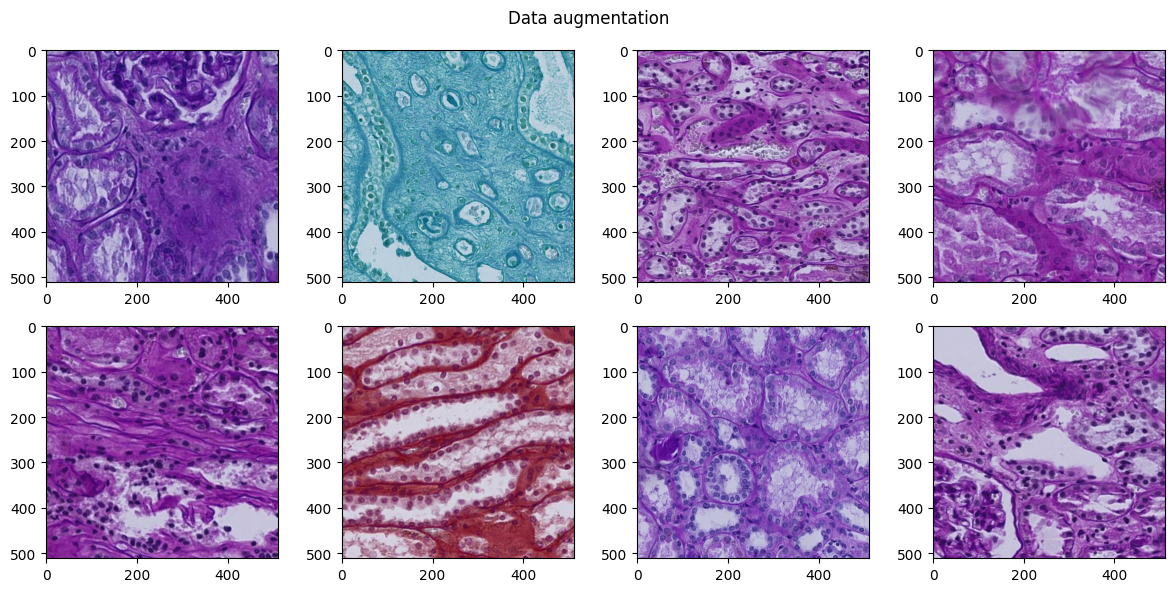

In [13]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(dataset))

        image = dataset[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Data augmentation')
plt.show()

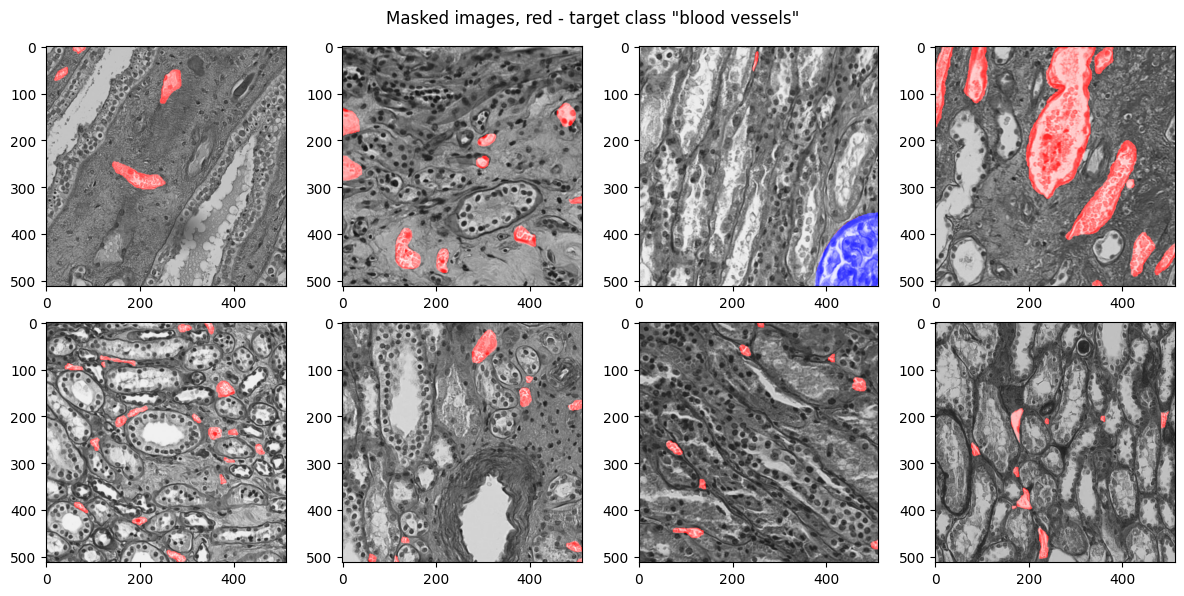

In [89]:
fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(dataset))

        img, msk = dataset[r_num]
        img, msk = img.numpy().transpose((1,2,0)), msk
        img, msk = img_denorm(img), msk.astype(np.uint8)
        mask_classes = np.zeros((512, 512, 2), dtype=np.uint8)
        mask_classes[:,:,0] = (msk==1)
        mask_classes[:,:,1] = (msk>1)

        if mask_classes.max():
            mask_classes = mask_classes*(255//mask_classes.max())

        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        bnw_img = np.stack((img,)*3, axis=-1)
        bnw_img[:,:,0] = cv.bitwise_or(bnw_img[:,:,0], mask_classes[:,:,0])
        bnw_img[:,:,2] = cv.bitwise_or(bnw_img[:,:,2], mask_classes[:,:,1])

        axs[i, j].imshow(bnw_img, cmap='gray')

fig.suptitle('Masked images, red - target class "blood vessels"')
plt.show()

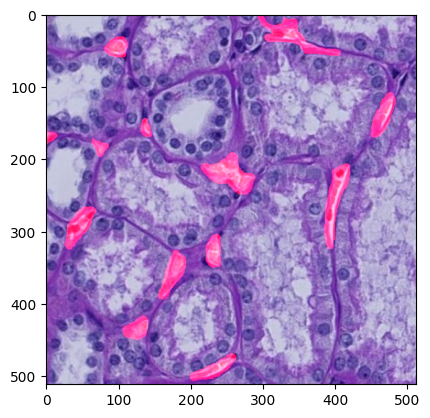

In [59]:


for img, msk in train_loader:
    # print(msk.shape, img.shape)
    image = img[0]
    img, msk = img[0], msk[0]
    img, msk = img.numpy().transpose((1,2,0)), msk.numpy()
    img, msk = img_denorm(img), msk.astype(np.uint8)
    if msk.max():
        msk = msk*(255//msk.max())
    # print(img.dtype, msk.max())
    
    plt.imshow(show_masked(img, msk))
    break

## MODEL and training

In [11]:
model = smp.Unet(encoder_name='mit_b4',
                         encoder_weights='imagenet',
                         decoder_channels=(512, 256, 128, 64, 32),
                         decoder_use_batchnorm=True,
                         classes=3,
                         activation=None)

model.segmentation_head[2] = nn.Softmax(dim=1)

# Loss_func = nn.CrossEntropyLoss()

model = model.float()

model.to(device)

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64

In [12]:
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')#, gamma=2, alpha=0.7) # a=0.7

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-05, weight_decay=1e-03)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-04)

In [14]:
# Exponential LR decay
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.5)

gamma = 0.96
epoch = 100
lr_0 = 1e-03

lr_t = pow(gamma, epoch)*lr_0
lr_t

1.6870319358849586e-05

In [18]:
# model.load_state_dict(torch.load('models\HuBMAP_U_mit_b3_wsi_XVII.pt'))

<All keys matched successfully>

In [15]:

metrics_all_classes = torchmetrics.JaccardIndex(task='multiclass', num_classes=3)

metrics = torchmetrics.JaccardIndex(task='binary')
metrics.to(device)
metrics_all_classes.to(device)


MulticlassJaccardIndex()

In [16]:
scaler = torch.cuda.amp.GradScaler()

In [22]:
n_epochs = 100
losses_train = np.zeros(n_epochs)
losses_test = np.zeros(n_epochs)
iou_test = np.zeros(n_epochs)
iou_all_test = np.zeros(n_epochs)
iou_2class = np.zeros(n_epochs)


for i in range(n_epochs):
    model.train()
    losses_epoch_train = []
    
    t0 = datetime.now()
    
    for inputs, targets in tqdm(train_loader):
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(device), targets.to(device)
    
        inputs = inputs.float()
    
        optimizer.zero_grad()
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = dice_loss(outputs, targets) + (1 * focal_loss(outputs, targets))
#         loss = Loss_func(outputs, targets)

    
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        losses_epoch_train.append(loss.item())
    
    lr_scheduler.step()
    
    losses_epoch_test = []
    iou = []
    iou_all_classes = []
    iou_2class_test = []
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
        
            inputs = inputs.float()
        
            outputs = model(inputs)
            loss = dice_loss(outputs, targets) + (1 * focal_loss(outputs, targets))
#             loss = Loss_func(outputs, targets)
#             outputs_argmax = np.argmax(outputs, axis=1)
            #Фиксировать iou для класса 1
            zrs = np.zeros((targets.shape[0], targets.shape[1],targets.shape[2]), dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1 
            zrs = torch.tensor(zrs).to(device)
            
            zrs_2 = np.zeros((targets.shape[0], targets.shape[1],targets.shape[2]), dtype=np.float32)
            zrs_2[targets.cpu().numpy()==2] = 1 
            zrs_2 = torch.tensor(zrs_2).to(device)
            
            iou.append(metrics(outputs[:,1,:,:], zrs).item())
            iou_2class_test.append(metrics(outputs[:,2,:,:], zrs_2).item())
            iou_all_classes.append(metrics_all_classes(outputs, targets).item())
            
            losses_epoch_test.append(loss.item())
        
    iou_all_test[i] = np.mean(iou_all_classes)    
    iou_test[i] = np.mean(iou)    
    losses_train[i] = np.mean(losses_epoch_train) 
    losses_test[i] = np.mean(losses_epoch_test)
    iou_2class[i] = np.nanmean(iou_2class_test)
    
    if np.mean(losses_epoch_test) == np.min(losses_test[:i+1]):
        torch.save(model.state_dict(), 'best__.pt')
        print(f'Best saved, loss: {np.mean(losses_epoch_test):.3f}')
     
    if n_epochs > 100 and i == 100:
        torch.save(model.state_dict(), '100_epochs__.pt')
        print(f'100 epochs weights saved!')
        
    dt = datetime.now() - t0
    
    print(f'Epoch: {i+1}/{n_epochs}, L_train: {losses_train[i]:.3f}\
    L_test: {losses_test[i]:.3f}, Time: {dt}\
    iou_1: {iou_test[i]:.3f}, iou_2:{iou_2class[i]:.3f}, iou_a:{iou_all_test[i]:.3f}')   
    torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Best saved, loss: 0.994
Epoch: 1/100, L_train: 0.996    L_test: 0.994, Time: 0:07:08.515516    iou_1: 0.648, iou_2:0.853, iou_a:0.825


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:46<00:00,  1.59s/it]


Epoch: 2/100, L_train: 1.002    L_test: 1.002, Time: 0:07:02.827563    iou_1: 0.640, iou_2:0.930, iou_a:0.844


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:46<00:00,  1.59s/it]


Epoch: 3/100, L_train: 1.005    L_test: 1.004, Time: 0:07:03.199369    iou_1: 0.653, iou_2:0.820, iou_a:0.818


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:02<00:00,  1.66s/it]


Best saved, loss: 0.991
Epoch: 4/100, L_train: 0.996    L_test: 0.991, Time: 0:07:15.277483    iou_1: 0.665, iou_2:0.821, iou_a:0.822


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:58<00:00,  1.65s/it]


Best saved, loss: 0.967
Epoch: 5/100, L_train: 0.998    L_test: 0.967, Time: 0:07:11.150988    iou_1: 0.652, iou_2:0.940, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 6/100, L_train: 0.997    L_test: 0.994, Time: 0:07:06.033565    iou_1: 0.628, iou_2:0.907, iou_a:0.834


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:45<00:00,  1.59s/it]


Epoch: 7/100, L_train: 0.993    L_test: 0.983, Time: 0:07:01.598922    iou_1: 0.640, iou_2:0.897, iou_a:0.834


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:55<00:00,  1.63s/it]


Epoch: 8/100, L_train: 0.999    L_test: 1.016, Time: 0:07:14.161417    iou_1: 0.654, iou_2:0.909, iou_a:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:47<00:00,  1.59s/it]


Epoch: 9/100, L_train: 0.979    L_test: 0.993, Time: 0:07:02.295951    iou_1: 0.663, iou_2:0.920, iou_a:0.849


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:03<00:00,  1.67s/it]


Epoch: 10/100, L_train: 0.998    L_test: 0.984, Time: 0:07:17.443791    iou_1: 0.644, iou_2:0.893, iou_a:0.835


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:56<00:00,  1.63s/it]


Epoch: 11/100, L_train: 0.987    L_test: 0.993, Time: 0:07:10.725012    iou_1: 0.648, iou_2:0.927, iou_a:0.847


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:58<00:00,  1.65s/it]


Epoch: 12/100, L_train: 0.993    L_test: 0.983, Time: 0:07:14.477437    iou_1: 0.656, iou_2:0.860, iou_a:0.830


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:13<00:00,  1.71s/it]


Epoch: 13/100, L_train: 0.994    L_test: 0.970, Time: 0:07:26.387251    iou_1: 0.656, iou_2:0.878, iou_a:0.835


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:09<00:00,  1.70s/it]


Epoch: 14/100, L_train: 0.983    L_test: 1.001, Time: 0:07:27.894538    iou_1: 0.660, iou_2:0.850, iou_a:0.829


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:03<00:00,  1.67s/it]


Epoch: 15/100, L_train: 0.989    L_test: 0.988, Time: 0:07:17.324623    iou_1: 0.670, iou_2:0.901, iou_a:0.847


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:52<00:00,  1.62s/it]


Epoch: 16/100, L_train: 1.008    L_test: 0.972, Time: 0:07:10.868092    iou_1: 0.643, iou_2:0.859, iou_a:0.826


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:58<00:00,  1.65s/it]


Epoch: 17/100, L_train: 0.997    L_test: 0.996, Time: 0:07:13.607354    iou_1: 0.670, iou_2:0.861, iou_a:0.836


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:56<00:00,  1.63s/it]


Epoch: 18/100, L_train: 0.999    L_test: 1.007, Time: 0:07:08.825223    iou_1: 0.665, iou_2:0.907, iou_a:0.849


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:57<00:00,  1.64s/it]


Epoch: 19/100, L_train: 0.993    L_test: 1.004, Time: 0:07:13.099873    iou_1: 0.665, iou_2:0.894, iou_a:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:02<00:00,  1.66s/it]


Epoch: 20/100, L_train: 0.998    L_test: 0.987, Time: 0:07:19.160192    iou_1: 0.660, iou_2:0.907, iou_a:0.844


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:00<00:00,  1.65s/it]


Epoch: 21/100, L_train: 0.988    L_test: 0.974, Time: 0:07:17.438219    iou_1: 0.669, iou_2:0.892, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 22/100, L_train: 0.988    L_test: 0.981, Time: 0:07:13.809887    iou_1: 0.650, iou_2:0.880, iou_a:0.834


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:14<00:00,  1.72s/it]


Epoch: 23/100, L_train: 0.996    L_test: 1.001, Time: 0:07:29.564407    iou_1: 0.656, iou_2:0.843, iou_a:0.826


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:15<00:00,  1.72s/it]


Epoch: 24/100, L_train: 0.998    L_test: 0.975, Time: 0:07:31.094563    iou_1: 0.666, iou_2:0.818, iou_a:0.821


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 25/100, L_train: 0.999    L_test: 1.003, Time: 0:07:17.261069    iou_1: 0.667, iou_2:0.851, iou_a:0.832


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:02<00:00,  1.66s/it]


Epoch: 26/100, L_train: 0.985    L_test: 0.986, Time: 0:07:20.993437    iou_1: 0.648, iou_2:0.887, iou_a:0.834


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 27/100, L_train: 0.998    L_test: 1.003, Time: 0:07:14.222334    iou_1: 0.663, iou_2:0.894, iou_a:0.842


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:48<00:00,  1.60s/it]


Epoch: 28/100, L_train: 0.992    L_test: 0.990, Time: 0:07:03.616696    iou_1: 0.663, iou_2:0.914, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:07<00:00,  1.68s/it]


Epoch: 29/100, L_train: 0.993    L_test: 0.996, Time: 0:07:26.069468    iou_1: 0.672, iou_2:0.821, iou_a:0.825


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:06<00:00,  1.68s/it]


Epoch: 30/100, L_train: 0.999    L_test: 0.990, Time: 0:07:19.824900    iou_1: 0.646, iou_2:0.840, iou_a:0.821


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:58<00:00,  1.64s/it]


Epoch: 31/100, L_train: 0.991    L_test: 0.990, Time: 0:07:13.687918    iou_1: 0.663, iou_2:0.915, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:06<00:00,  1.68s/it]


Epoch: 32/100, L_train: 0.991    L_test: 1.002, Time: 0:07:21.675681    iou_1: 0.652, iou_2:0.818, iou_a:0.817


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:08<00:00,  1.69s/it]


Epoch: 33/100, L_train: 1.000    L_test: 0.993, Time: 0:07:25.392034    iou_1: 0.653, iou_2:0.891, iou_a:0.838


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:17<00:00,  1.73s/it]


Epoch: 34/100, L_train: 0.990    L_test: 0.978, Time: 0:07:30.502408    iou_1: 0.671, iou_2:0.892, iou_a:0.844


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:07<00:00,  1.69s/it]


Best saved, loss: 0.966
Epoch: 35/100, L_train: 0.985    L_test: 0.966, Time: 0:07:26.137332    iou_1: 0.676, iou_2:0.805, iou_a:0.822


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 36/100, L_train: 0.984    L_test: 1.013, Time: 0:07:17.563787    iou_1: 0.672, iou_2:0.873, iou_a:0.841


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:08<00:00,  1.69s/it]


Epoch: 37/100, L_train: 0.993    L_test: 0.971, Time: 0:07:24.820445    iou_1: 0.673, iou_2:0.897, iou_a:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:05<00:00,  1.68s/it]


Epoch: 38/100, L_train: 0.979    L_test: 0.987, Time: 0:07:24.730371    iou_1: 0.686, iou_2:0.847, iou_a:0.838


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:09<00:00,  1.70s/it]


Epoch: 39/100, L_train: 0.989    L_test: 1.008, Time: 0:07:26.182816    iou_1: 0.673, iou_2:0.896, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:05<00:00,  1.67s/it]


Epoch: 40/100, L_train: 0.995    L_test: 1.001, Time: 0:07:22.056822    iou_1: 0.672, iou_2:0.878, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:57<00:00,  1.64s/it]


Epoch: 41/100, L_train: 1.008    L_test: 0.992, Time: 0:07:12.220112    iou_1: 0.675, iou_2:0.895, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:10<00:00,  1.70s/it]


Epoch: 42/100, L_train: 0.994    L_test: 0.987, Time: 0:07:32.654977    iou_1: 0.679, iou_2:0.914, iou_a:0.855


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:35<00:00,  1.81s/it]


Epoch: 43/100, L_train: 0.998    L_test: 0.989, Time: 0:07:51.484426    iou_1: 0.670, iou_2:0.839, iou_a:0.830


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:01<00:00,  1.66s/it]


Epoch: 44/100, L_train: 1.001    L_test: 1.000, Time: 0:07:20.144957    iou_1: 0.663, iou_2:0.873, iou_a:0.838


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:14<00:00,  1.72s/it]


Epoch: 45/100, L_train: 0.981    L_test: 1.017, Time: 0:07:27.065593    iou_1: 0.672, iou_2:0.845, iou_a:0.832


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 46/100, L_train: 0.993    L_test: 1.015, Time: 0:07:14.145025    iou_1: 0.669, iou_2:0.933, iou_a:0.859


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 47/100, L_train: 0.989    L_test: 1.000, Time: 0:07:06.385519    iou_1: 0.669, iou_2:0.901, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 48/100, L_train: 0.991    L_test: 1.001, Time: 0:07:06.639798    iou_1: 0.668, iou_2:0.889, iou_a:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:41<00:00,  1.57s/it]


Epoch: 49/100, L_train: 0.993    L_test: 0.981, Time: 0:06:53.540286    iou_1: 0.672, iou_2:0.920, iou_a:0.853


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:26<00:00,  1.50s/it]


Epoch: 50/100, L_train: 0.985    L_test: 0.993, Time: 0:06:34.229993    iou_1: 0.682, iou_2:0.902, iou_a:0.852


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:22<00:00,  1.48s/it]


Epoch: 51/100, L_train: 0.996    L_test: 0.997, Time: 0:06:34.920014    iou_1: 0.661, iou_2:0.886, iou_a:0.840


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:27<00:00,  1.50s/it]


Epoch: 52/100, L_train: 0.987    L_test: 0.995, Time: 0:06:34.309800    iou_1: 0.668, iou_2:0.865, iou_a:0.838


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:34<00:00,  1.54s/it]


Epoch: 53/100, L_train: 0.995    L_test: 0.973, Time: 0:06:46.165125    iou_1: 0.683, iou_2:0.888, iou_a:0.848


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:32<00:00,  1.53s/it]


Epoch: 54/100, L_train: 1.000    L_test: 0.990, Time: 0:06:46.957759    iou_1: 0.671, iou_2:0.854, iou_a:0.835


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:33<00:00,  1.53s/it]


Epoch: 55/100, L_train: 0.991    L_test: 1.001, Time: 0:06:46.773951    iou_1: 0.664, iou_2:0.906, iou_a:0.847


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:32<00:00,  1.53s/it]


Epoch: 56/100, L_train: 1.000    L_test: 0.997, Time: 0:06:44.834611    iou_1: 0.680, iou_2:0.874, iou_a:0.844


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:44<00:00,  1.58s/it]


Epoch: 57/100, L_train: 0.993    L_test: 1.004, Time: 0:06:59.610363    iou_1: 0.677, iou_2:0.886, iou_a:0.847


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:48<00:00,  1.60s/it]


Epoch: 58/100, L_train: 1.003    L_test: 0.988, Time: 0:07:04.847815    iou_1: 0.686, iou_2:0.885, iou_a:0.849


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:41<00:00,  1.57s/it]


Epoch: 59/100, L_train: 0.992    L_test: 1.007, Time: 0:06:54.483059    iou_1: 0.675, iou_2:0.866, iou_a:0.840


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:54<00:00,  1.62s/it]


Epoch: 60/100, L_train: 0.986    L_test: 0.995, Time: 0:07:11.497537    iou_1: 0.663, iou_2:0.884, iou_a:0.840


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:54<00:00,  1.63s/it]


Epoch: 61/100, L_train: 0.997    L_test: 1.001, Time: 0:07:12.654835    iou_1: 0.669, iou_2:0.878, iou_a:0.840


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:55<00:00,  1.63s/it]


Epoch: 62/100, L_train: 0.997    L_test: 1.004, Time: 0:07:10.274124    iou_1: 0.691, iou_2:0.922, iou_a:0.863


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:41<00:00,  1.57s/it]


Epoch: 63/100, L_train: 0.989    L_test: 0.969, Time: 0:06:53.667955    iou_1: 0.673, iou_2:0.881, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:01<00:00,  1.66s/it]


Epoch: 64/100, L_train: 0.996    L_test: 1.014, Time: 0:07:18.676284    iou_1: 0.689, iou_2:0.892, iou_a:0.853


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:56<00:00,  1.63s/it]


Epoch: 65/100, L_train: 0.992    L_test: 0.983, Time: 0:07:15.293452    iou_1: 0.689, iou_2:0.899, iou_a:0.854


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:42<00:00,  1.57s/it]


Epoch: 66/100, L_train: 1.002    L_test: 1.004, Time: 0:06:57.513387    iou_1: 0.670, iou_2:0.855, iou_a:0.833


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:52<00:00,  1.62s/it]


Epoch: 67/100, L_train: 1.004    L_test: 1.012, Time: 0:07:11.853726    iou_1: 0.676, iou_2:0.900, iou_a:0.851


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:42<00:00,  1.57s/it]


Epoch: 68/100, L_train: 0.992    L_test: 0.995, Time: 0:06:54.815662    iou_1: 0.685, iou_2:0.863, iou_a:0.841


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:03<00:00,  1.67s/it]


Epoch: 69/100, L_train: 0.986    L_test: 0.990, Time: 0:07:20.759923    iou_1: 0.663, iou_2:0.908, iou_a:0.847


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:03<00:00,  1.67s/it]


Epoch: 70/100, L_train: 0.984    L_test: 0.967, Time: 0:07:20.863822    iou_1: 0.686, iou_2:0.893, iou_a:0.851


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:53<00:00,  1.62s/it]


Epoch: 71/100, L_train: 0.998    L_test: 0.988, Time: 0:07:10.664642    iou_1: 0.696, iou_2:0.904, iou_a:0.858


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:42<00:00,  1.57s/it]


Epoch: 72/100, L_train: 1.007    L_test: 1.012, Time: 0:06:57.260089    iou_1: 0.685, iou_2:0.923, iou_a:0.862


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:48<00:00,  1.60s/it]


Epoch: 73/100, L_train: 0.992    L_test: 1.009, Time: 0:07:03.792315    iou_1: 0.676, iou_2:0.877, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:50<00:00,  1.61s/it]


Epoch: 74/100, L_train: 0.989    L_test: 0.998, Time: 0:07:08.032731    iou_1: 0.675, iou_2:0.920, iou_a:0.857


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:39<00:00,  1.56s/it]


Epoch: 75/100, L_train: 0.990    L_test: 0.997, Time: 0:06:50.971588    iou_1: 0.681, iou_2:0.804, iou_a:0.825


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:48<00:00,  1.60s/it]


Epoch: 76/100, L_train: 0.981    L_test: 0.973, Time: 0:06:59.921590    iou_1: 0.671, iou_2:0.908, iou_a:0.849


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:43<00:00,  1.58s/it]


Epoch: 77/100, L_train: 0.994    L_test: 0.995, Time: 0:06:59.317573    iou_1: 0.670, iou_2:0.834, iou_a:0.829


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:47<00:00,  1.60s/it]


Epoch: 78/100, L_train: 0.988    L_test: 0.971, Time: 0:07:02.612941    iou_1: 0.680, iou_2:0.841, iou_a:0.835


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:44<00:00,  1.58s/it]


Epoch: 79/100, L_train: 0.988    L_test: 0.988, Time: 0:06:56.592779    iou_1: 0.697, iou_2:0.888, iou_a:0.855


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:49<00:00,  1.60s/it]


Epoch: 80/100, L_train: 0.995    L_test: 0.998, Time: 0:07:02.825791    iou_1: 0.668, iou_2:0.865, iou_a:0.836


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:11<00:00,  1.70s/it]


Epoch: 81/100, L_train: 0.990    L_test: 0.974, Time: 0:07:28.168118    iou_1: 0.685, iou_2:0.871, iou_a:0.843


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:07<00:00,  1.68s/it]


Epoch: 82/100, L_train: 1.000    L_test: 0.988, Time: 0:07:23.616185    iou_1: 0.680, iou_2:0.860, iou_a:0.839


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:38<00:00,  1.55s/it]


Epoch: 83/100, L_train: 0.983    L_test: 0.988, Time: 0:06:54.357746    iou_1: 0.673, iou_2:0.892, iou_a:0.846


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:47<00:00,  1.60s/it]


Epoch: 84/100, L_train: 0.999    L_test: 0.996, Time: 0:07:04.714399    iou_1: 0.688, iou_2:0.845, iou_a:0.839


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:58<00:00,  1.64s/it]


Epoch: 85/100, L_train: 0.992    L_test: 1.008, Time: 0:07:15.730246    iou_1: 0.675, iou_2:0.883, iou_a:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:47<00:00,  1.59s/it]


Epoch: 86/100, L_train: 0.992    L_test: 0.996, Time: 0:07:07.070012    iou_1: 0.680, iou_2:0.911, iou_a:0.854


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 87/100, L_train: 0.987    L_test: 1.013, Time: 0:07:06.745337    iou_1: 0.691, iou_2:0.925, iou_a:0.864


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 88/100, L_train: 0.990    L_test: 1.012, Time: 0:07:07.495894    iou_1: 0.687, iou_2:0.920, iou_a:0.861


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:54<00:00,  1.63s/it]


Epoch: 89/100, L_train: 0.980    L_test: 0.994, Time: 0:07:10.541705    iou_1: 0.694, iou_2:0.930, iou_a:0.866


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:46<00:00,  1.59s/it]


Epoch: 90/100, L_train: 0.998    L_test: 0.991, Time: 0:06:57.392330    iou_1: 0.688, iou_2:0.929, iou_a:0.862


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:37<00:00,  1.55s/it]


Epoch: 91/100, L_train: 0.996    L_test: 0.994, Time: 0:06:51.683868    iou_1: 0.671, iou_2:0.935, iou_a:0.858


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:38<00:00,  1.55s/it]


Epoch: 92/100, L_train: 0.992    L_test: 1.009, Time: 0:06:50.269001    iou_1: 0.694, iou_2:0.899, iou_a:0.856


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:44<00:00,  1.58s/it]


Epoch: 93/100, L_train: 1.000    L_test: 0.971, Time: 0:06:56.682097    iou_1: 0.688, iou_2:0.813, iou_a:0.824


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:37<00:00,  1.55s/it]


Epoch: 94/100, L_train: 0.994    L_test: 0.984, Time: 0:06:48.965403    iou_1: 0.682, iou_2:0.908, iou_a:0.854


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:51<00:00,  1.61s/it]


Epoch: 95/100, L_train: 0.997    L_test: 0.992, Time: 0:07:06.542321    iou_1: 0.699, iou_2:0.883, iou_a:0.854


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [06:15<00:00,  1.72s/it]


Epoch: 96/100, L_train: 0.997    L_test: 0.982, Time: 0:07:30.188417    iou_1: 0.699, iou_2:0.889, iou_a:0.855


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:59<00:00,  1.65s/it]


Epoch: 97/100, L_train: 0.991    L_test: 1.005, Time: 0:07:14.760029    iou_1: 0.698, iou_2:0.878, iou_a:0.851


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:57<00:00,  1.64s/it]


Epoch: 98/100, L_train: 0.990    L_test: 1.005, Time: 0:07:16.308474    iou_1: 0.683, iou_2:0.922, iou_a:0.860


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:46<00:00,  1.59s/it]


Epoch: 99/100, L_train: 1.000    L_test: 0.998, Time: 0:07:00.638085    iou_1: 0.706, iou_2:0.863, iou_a:0.850


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [05:43<00:00,  1.57s/it]


Epoch: 100/100, L_train: 0.997    L_test: 0.993, Time: 0:06:54.098643    iou_1: 0.684, iou_2:0.946, iou_a:0.865


In [34]:
torch.cuda.empty_cache()

Второй класс уже достаточно сошелся, мб для концентрации на первом классе уменьшить кропп

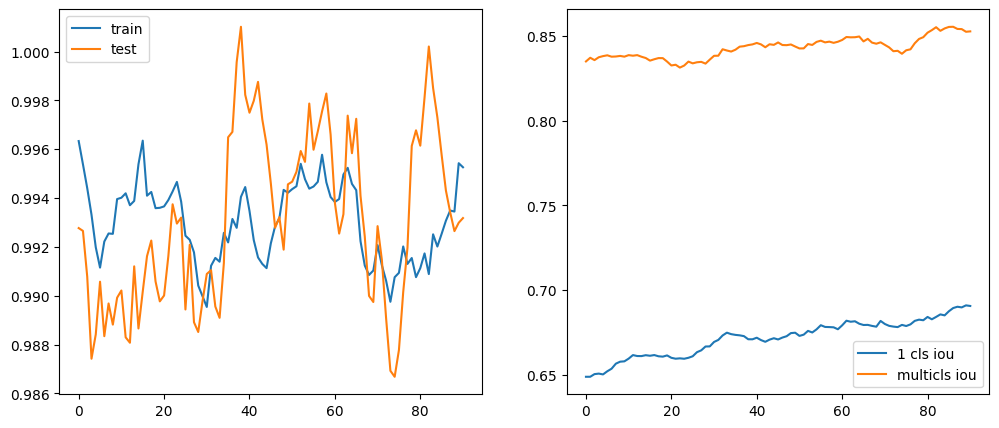

In [25]:
# W Moving Average

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(moving_average(losses_train), label = 'train')
plt.plot(moving_average(losses_test), label='test')
plt.legend()

plt.subplot(1,2,2) 
plt.plot(moving_average(iou_test), label = '1 cls iou')
plt.plot(moving_average(iou_all_test), label = 'multicls iou')
plt.legend()

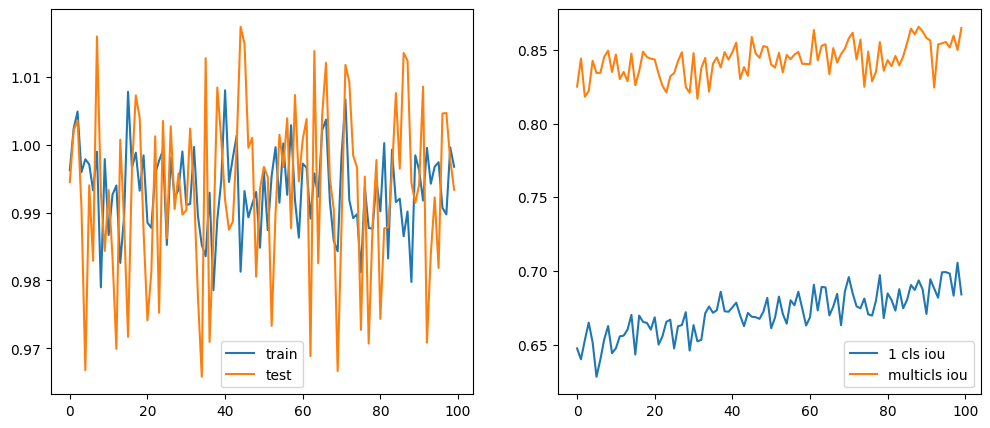

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_train, label = 'train')
plt.plot(losses_test, label='test')
plt.legend()

plt.subplot(1,2,2) 
plt.plot(iou_test, label = '1 cls iou')
plt.plot(iou_all_test, label = 'multicls iou')
plt.legend()

In [23]:
torch.save(model.state_dict(), 'models\HuBMAP_U_mit_b3_wsi_2lateII.pt')

In [19]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Stuff

In [26]:
with open(tile_meta_path) as f:
    tile_meta = pd.read_csv(f)

In [29]:
img_names = os.listdir('HuBMAP dataset\imgs')

for name in img_names:
    

In [30]:
img_names

['0006ff2aa7cd.tif',
 '00168d1b7522.tif',
 '0033bbc76b6b.tif',
 '003504460b3a.tif',
 '004daf1cbe75.tif',
 '005715f0a313.tif',
 '00654cc08aac.tif',
 '00656c6f2690.tif',
 '0067d5ad2250.tif',
 '00ca2f4c8918.tif',
 '00d75ad65de3.tif',
 '00da70813521.tif',
 '00da8fdf2391.tif',
 '00f560a6a72b.tif',
 '014b60dfe193.tif',
 '016c33dacfa1.tif',
 '019390572feb.tif',
 '01a7fca6263b.tif',
 '025ec20b8b73.tif',
 '0276eb166cce.tif',
 '02cf5c2db152.tif',
 '02d2022943a4.tif',
 '02f563532696.tif',
 '033a656390b2.tif',
 '033e91059cec.tif',
 '03d335057db3.tif',
 '041588f936e1.tif',
 '041ad8166762.tif',
 '041b985201d6.tif',
 '0478279e6e16.tif',
 '04c08080b2ae.tif',
 '04eaacfbb9f6.tif',
 '055348e2fece.tif',
 '0596bfb19322.tif',
 '05dd21a61705.tif',
 '06034408218a.tif',
 '065ed4490163.tif',
 '0667203ecaac.tif',
 '0672b96aaccc.tif',
 '06b972c417e7.tif',
 '0717863ca2cb.tif',
 '07199abc71ec.tif',
 '072f5307f243.tif',
 '0754412b2917.tif',
 '0765f249adeb.tif',
 '0788fc3be62e.tif',
 '07b809228ef4.tif',
 '07bdbe578de

In [ ]:
tile_meta_train = tile_meta[tile_meta.id

In [6]:
wsi_labels = np.unique(tile_meta.source_wsi)

wsi_labels

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64)

In [73]:
for label in wsi_labels:
    all_tiles = tile_meta[tile_meta.source_wsi == label]
    print(len(all_tiles))

507
445
410
271
600
600
600
600
600
600
600
600
600


In [7]:
df_wsi_1 = tile_meta[tile_meta.source_wsi == 1]
min_max_coord = [df_wsi_1.i.min(), df_wsi_1.j.min(), df_wsi_1.i.max(),  df_wsi_1.j.max()]
col_min, row_min, col_max, row_max = min_max_coord
df_wsi_1.reset_index(drop=True, inplace=True)

In [49]:
df_wsi_2 = tile_meta[tile_meta.source_wsi == 2]
min_max_coord = [df_wsi_2.i.min(), df_wsi_2.j.min(), df_wsi_2.i.max(),  df_wsi_2.j.max()]
col_min, row_min, col_max, row_max = min_max_coord
df_wsi_2.reset_index(drop=True, inplace=True)

In [71]:
df_wsi_3 = tile_meta[tile_meta.source_wsi == 3]
min_max_coord = [df_wsi_3.i.min(), df_wsi_3.j.min(), df_wsi_3.i.max(),  df_wsi_3.j.max()]
col_min, row_min, col_max, row_max = min_max_coord
df_wsi_3.reset_index(drop=True, inplace=True)

In [92]:
df_wsi_4 = tile_meta[tile_meta.source_wsi == 4]
min_max_coord = [df_wsi_4.i.min(), df_wsi_4.j.min(), df_wsi_4.i.max(),  df_wsi_4.j.max()]
col_min, row_min, col_max, row_max = min_max_coord
df_wsi_4.reset_index(drop=True, inplace=True)

In [93]:
wsi = np.zeros(((row_max+512), (col_max+512), 3), dtype=np.uint8)

for i in range(len(df_wsi_4)):
    tile_name = df_wsi_4.id[i] + '.tif'
    tile_path = os.path.join(img_path, tile_name)    
    
    row_coord = df_wsi_4.j[i]
    col_coord = df_wsi_4.i[i]
    
    
    
#     print(row_coord, col_coord)
    with Image.open(tile_path) as tile:
        wsi[row_coord:(row_coord+512), col_coord:(col_coord+512), :] = np.array(tile)

In [94]:
wsi.shape

(27648, 13824, 3)

In [40]:
wsi_1_pt1 = wsi[2500:12000,6500:,:]

In [46]:
wsi_1_pt2 = wsi[38000:,2000:12000,:]

In [68]:
wsi_2_pt1 = wsi[11800:,14000:,:]

In [80]:
wsi_3_pt1 = wsi[2500:9300, 6400:,:]

In [77]:
wsi_3_pt2 = wsi[10000:,2000:9500,:]

In [98]:
wsi_4_pt1 = wsi[20900:,1500:,:]

In [70]:
np.save('HuBMAP dataset\WSIs\wsi_2' ,wsi_2_pt1)

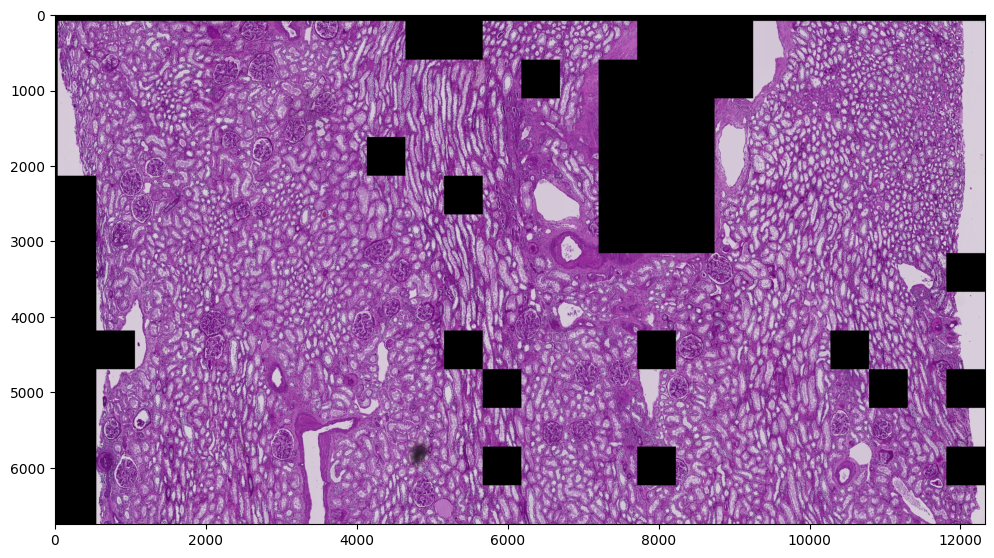

In [97]:
plt.figure(figsize=(12,12))
plt.imshow(wsi[20900:,1500:,:])

In [ ]:
# Составляем WSI изображения с масками
with open(tile_meta_path) as f:
    tile_meta = pd.read_csv(f)

with open(json_file) as f:
    polygons = pd.read_json(f, lines=True)
    
#  Для каждой wsi считываем размер 
for n in range(1, 5):
    df_wsi = tile_meta[tile_meta.source_wsi == n]
    min_max_coord = [df_wsi.i.min(), df_wsi.j.min(), df_wsi.i.max(),  df_wsi.j.max()]
    col_min, row_min, col_max, row_max = min_max_coord
    df_wsi.reset_index(drop=True, inplace=True)
    
    wsi = np.zeros(((row_max+512), (col_max+512), 3), dtype=np.uint8)
    wsi_mask = wsi.copy()

    for i in range(len(df_wsi)):
        tile_name = df_wsi.id[i] + '.tif'
        tile_path = os.path.join(img_path, tile_name)    
    
        row_coord = df_wsi.j[i]
        col_coord = df_wsi.i[i]
    
        with Image.open(tile_path) as tile:
            wsi[row_coord:(row_coord+512), col_coord:(col_coord+512), :] = np.array(tile)
            
        # считываем маску для одного tile
        mask = np.zeros((512,512), dtype=np.uint8)
        
        img_name = tile_name.rstrip('.tif')
        index = polygons.index[polygons.id == img_name]
        
        for coord_dict in polygons.annotations[index]:
            if coord_dict['type'] == 'blood_vessel':
                pts = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(mask, pts=[pts], color=1)
        
            if coord_dict['type'] == 'glomerulus':
                pts = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(mask, pts=[pts], color=2)
        
            if coord_dict['type'] == 'unsure':
                pts = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(mask, pts=[pts], color=3)
                
        wsi_mask[row_coord:(row_coord+512), col_coord:(col_coord+512), :] = mask

In [ ]:
# # Тоже самое но для неразмеченных данных с псевдолейблами

# class TileNineByNine(Dataset):
    
#     def __init__(self, no_masks_path, pseudo_path, tile_meta_path):
#         with open(tile_meta_path) as f:
#             self.tile_meta = pd.read_csv(f)
#             self.tile_meta = self.tile_meta[self.tile_meta.source_wsi > 4]
            
#         with open(pseudo_path) as f:
#             self.polygons = pd.read_json(f)
            
#         self.images_path = no_masks_path
        
#     def __len__(self):
#         return len(self.polygons)
    
#     def transformation(self, image, mask):
        
#         need_crop = (image.shape[0] > 512)
        
#         image = Image.fromarray(image)
#         mask_img = Image.fromarray(mask)
        
#         rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
        
#         if need_crop:
#             crop_size = np.random.choice(range(412, 812)) #1530
#             crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
#             image = TF.resized_crop(image,*crop_params,(512,512))
#             mask_img = TF.resized_crop(mask_img,*crop_params,(512,512))
        
#         flip = np.random.random()

#         flip_v = np.random.random()
#         pad = np.random.random()
#         jitter = np.random.random()
        
        
            
#         if jitter > 0.3:
#             image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
#         image = TF.rotate(image,rotate_params)
            
#         if flip > 0.7:
#             image = TF.hflip(image)
            
#         if flip_v > 0.7:
#             image = TF.vflip(image)       
        
#         mask_img = TF.rotate(mask_img,rotate_params)
                
#         if flip > 0.7:
#             mask_img = TF.hflip(mask_img)
                
#         if flip_v > 0.7:
#             mask_img = TF.vflip(mask_img)
                       
                
#         mask = (np.array(mask_img))           
            
#         return (image, mask)
    
#     def __getitem__(self, index):
#         if torch.is_tensor(index):
#             index = index.tolist()
            
#         norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
#         img_name = self.polygons.id[index]

#         img_name = img_name[:-4]
        
#         image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
#         image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
#         mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)
        
#         # Для image нужно получить #wsi и координаты i,j
#         n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

#         self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
#         col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
#         self.tile_meta.j[self.tile_meta.id == img_name].item()
        
        
#         # Левый верхн угол
#         init_row = row_coord - 512
        
#         # Заполняем большое изображение
#         is_blank_flag = False
#         y = 0
#         for i in range(3):
#             x=0
#             init_col = col_coord - 512

#             for j in range(3):
                
#                 image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
#                                                                     (self.df_wsi.j == init_row))]

#                 # Тут, если пусттая картинка, то брать только центральную картинку
#                 if image_small_name.empty:
#                     is_blank_flag = True
#                     image_large = np.array(image)
# #                     print('One image')
                    
#                     n_targets = len(self.polygons.labels[index])
#                     mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
#                     for n in range(n_targets):
#                         label = n+1
#                         col, row = self.polygons.labels[index][str(label)]
#                         mask_large[col, row] = label
        
#                     break
#             #         x += 512
# #                     init_col += 512
# #                     continue
            
            
#                 image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')
                
#                 with Image.open(image_small_path) as image_small:
#                     image_large[y:y+512,x:x+512,:] = np.array(image_small)
                
#                 index_mask = self.polygons.index[self.polygons.id == (image_small_name.item()+'.tif')].item()
                
#                 # Вставили картинку, теперь маску
#                 mask = np.zeros((512, 512), dtype=np.uint8)
                
#                 n_targets = len(self.polygons.labels[index_mask])
                
#                 for n in range(n_targets):
#                     label = n+1
#                     col, row = self.polygons.labels[index_mask][str(label)]
#                     mask[col, row] = label
                    
#                 mask_large[y:y+512,x:x+512] = mask   
                
#                 x += 512
#                 init_col += 512
            
#             if is_blank_flag:
#                 break
#             y += 512
#             init_row += 512
            
            
#         image_large, mask_large = self.transformation(image_large, mask_large)
        
#         image_large = np.array(image_large).transpose((2, 0, 1))
#         if image_large.max():
#             image_large = image_large/image_large.max()
        
#         image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
#         return image_large, mask_large.astype(np.float32)

In [ ]:
# # Все картинки передаются в исходном виде

# class TileNineByNine(Dataset):
    
#     def __init__(self, json_file, images_path, tile_meta_path):
#         with open(tile_meta_path) as f:
#             self.tile_meta = pd.read_csv(f)

#         with open(json_file) as f:
#             self.polygons = pd.read_json(f, lines=True)
            
#         self.images_path = images_path
        
#     def __len__(self):
#         return len(self.polygons)
    
#     def transformation(self, image, mask):
        
#         need_crop = (image.shape[0] > 512)
        
#         image = Image.fromarray(image)
#         mask_img = Image.fromarray(mask)
        
#         rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
        
#         if need_crop:
#             crop_size = np.random.choice(range(412, 512)) #1530
#             crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
#             image = TF.resized_crop(image,*crop_params,(512,512))
#             mask_img = TF.resized_crop(mask_img,*crop_params,(512,512))
        
#         flip = np.random.random()

#         flip_v = np.random.random()
#         pad = np.random.random()
#         jitter = np.random.random()
        
        
            
#         if jitter > 0.3:
#             image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
#         image = TF.rotate(image,rotate_params)
            
#         if flip > 0.7:
#             image = TF.hflip(image)
            
#         if flip_v > 0.7:
#             image = TF.vflip(image)       
        
#         mask_img = TF.rotate(mask_img,rotate_params)
                
#         if flip > 0.7:
#             mask_img = TF.hflip(mask_img)
                
#         if flip_v > 0.7:
#             mask_img = TF.vflip(mask_img)
                       
                
#         mask = (np.array(mask_img))           
            
#         return (image, mask)
    
#     def __getitem__(self, index):
#         if torch.is_tensor(index):
#             index = index.tolist()
            
#         norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
#         img_name = self.polygons.iloc[index, 0]                              
        
#         image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
#         image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
#         mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)
        
#         # Для image нужно получить #wsi и координаты i,j
#         n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

#         self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
#         col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
#         self.tile_meta.j[self.tile_meta.id == img_name].item()
        
        
#         # Левый верхн угол
#         init_row = row_coord - 512
        
#         # Заполняем большое изображение
#         is_blank_flag = False
#         y = 0
#         for i in range(3):
#             x=0
#             init_col = col_coord - 512

#             for j in range(3):
                
#                 image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
#                                                                     (self.df_wsi.j == init_row))]
                
#                                 # Тут, если пусттая картинка, то брать только центральную картинку
#                 if True:
#                     is_blank_flag = True
#                     image_large = np.array(image)
# #                     print('One image')
                    
#                     mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
#                     for coord_dict in self.polygons.annotations[index]:
#                         if coord_dict['type'] == 'blood_vessel':
#                             pts = np.array(coord_dict['coordinates'][0])
#                             cv.fillPoly(mask_large, pts=[pts], color=1)
        
#                         if coord_dict['type'] == 'glomerulus':
#                             pts = np.array(coord_dict['coordinates'][0])
#                             cv.fillPoly(mask_large, pts=[pts], color=2)
                        
# #                     if coord_dict['type'] == 'unsure':
# #                         pts = np.array(coord_dict['coordinates'][0])
# #                         cv.fillPoly(mask, pts=[pts], color=3)
                        
#                     break

# #                
#                 break
            
            
#         image_large, mask_large = self.transformation(image_large, mask_large)
        
#         image_large = np.array(image_large).transpose((2, 0, 1))
#         if image_large.max():
#             image_large = image_large/image_large.max()
        
#         image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
#         return image_large, mask_large.astype(np.float32)